<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/First_Pass_Model/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import Union

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cpu'

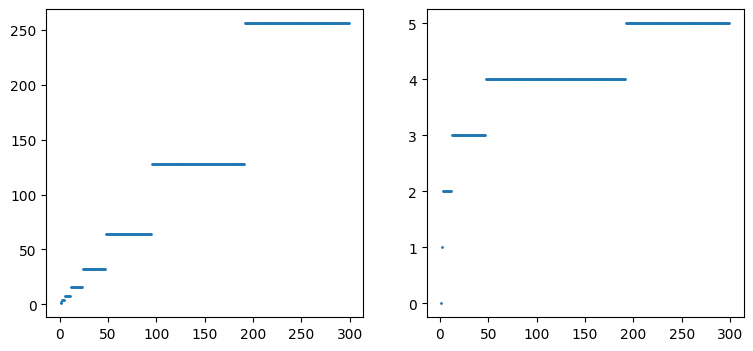

In [3]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
x = np.arange(1, 300)
amin = np.argmin(
    [
        np.abs(2**np.ceil(np.log2(x)) - x),
        np.abs(2**np.floor(np.log2(x)) - x)
    ],
    axis=0
)
v1 = np.empty_like(x)
v2 = np.empty_like(x)
for i, v in enumerate(x):
    v1[i] = [2**np.ceil(np.log2(v)), 2**np.floor(np.log2(v))][amin[i]]
    v2[i] = np.ceil([np.ceil(np.log2(v)), np.floor(np.log2(v))][amin[i]]/1.75)
axs[0].scatter(x, v1, s=1)
axs[1].scatter(x, v2, s=1)
plt.show(fig)

In [4]:
class EmitEcostressDataset(Dataset):
    def __init__(
        self,
        emit_data_path: Union[str, None] = None,
        emit_data: Union[np.ndarray, None] = None,
        ecostress_data_path: Union[str, None] = None,
        ecostress_data: Union[np.ndarray, None] = None,
        additional_data_paths: Union[tuple[str], None] = None,
        additional_data: Union[tuple[np.ndarray], None] = None,
    ):
        '''
        Builds a pytorch dataset for predicting ECOSTRESS LST
        from EMIT spectra and any given additional data

        Input:
        emit_data_path: path to emit data, not used if emit_data != None
        emit_data: 2- or 3- dimensional np array of emit data
        ecostress_data_path: path to ecostress data,
                             not used if ecostress_data != None
        ecostress_data: 1- or 2- dimensional np array of ecostress data
        additional_data_paths: tuple of paths to supplementary datasets
                               used for additional model input
        additional_data: tuple of 1-, 2-, or 3-dimensional np arrays of
                         supplementary data used for additional model input

        * Note that emit_data and ecostress_data will take precedence
          over emit_data_path and ecostress_data_path, respectively,
          but additional_data_paths and additional_data can both be specified,
          and if additional_data_paths specifies a path to data already
          in additional_data, a duplicate will be added
        '''
        if emit_data_path != None and emit_data == None:
            emit_data = np.load(emit_data_path)
        if emit_data is not None:
            if len(emit_data.shape) == 2:
                self.emit_data = emit_data
            elif len(emit_data.shape) == 3:
                self.emit_data = emit_data.reshape(
                    (
                        emit_data.shape[0] * emit_data.shape[1],
                        emit_data.shape[2]
                    )
                )
            else:
                raise ValueError(
                    'emit_data must be 2- or 3-dimensional, '
                    f'found {len(emit_data.shape)}-dimensional'
                )
        else:
            raise ValueError(
                'Either emit_data_path or emit_data must not be None'
            )

        if ecostress_data_path != None and ecostress_data == None:
            ecostress_data = np.load(ecostress_data_path)
        if ecostress_data is not None:
            if len(ecostress_data.shape) == 1:
                self.ecostress_data = ecostress_data
            elif len(ecostress_data.shape) == 2:
                self.ecostress_data = ecostress_data.reshape(
                    ecostress_data.shape[0] * ecostress_data.shape[1]
                )
            else:
                raise ValueError(
                    'ecostress_data must be 2- or 3-dimensional, '
                    f'found {len(ecostress_data.shape)}-dimensional'
                )
        else:
            raise ValueError(
                'Either ecostress_data_path or ecostress_data must not be None'
            )

        assert self.emit_data.shape[0] == self.ecostress_data.shape[0], \
            'emit_data and ecostress_data must have the length, ' \
            f'got {self.emit_data.shape[0]} and {self.ecostress_data.shape[0]}'

        self.additional_data = []
        if additional_data != None:
            for i in range(len(additional_data)):
                if len(additional_data[i].shape) == 1:
                    self.additional_data.append(additional_data[i])
                if len(additional_data[i].shape) == 2:
                    self.additional_data.append(additional_data[i])
                elif len(additional_data[i].shape) == 3:
                    self.additional_data.append(
                        additional_data[i].reshape(
                            (
                                additional_data[i].shape[0] *
                                additional_data[i].shape[1],
                                additional_data[i].shape[2]
                            )
                        )
                    )
                else:
                    raise ValueError(
                        f'Item at index {i} in additional_data must be'
                        '1-, 2-, or 3-dimensional, '
                        f'found {len(additional_data[i].shape)}-dimensional'
                    )

        if additional_data_paths != None:
            for i in range(len(additional_data_paths)):
                additional_data_element  = np.load(additional_data_paths[i])
                if len(additional_data_element.shape) == 1:
                    self.additional_data.append(
                        additional_data_element.reshape(
                            (additional_data_element.shape[0], 1)
                        )
                    )
                if len(additional_data_element.shape) == 2:
                    self.additional_data.append(additional_data_element)
                elif len(additional_data_element.shape) == 3:
                    self.additional_data.append(
                        additional_data_element.reshape(
                            (
                                additional_data_element.shape[0] *
                                additional_data_element.shape[1],
                                additional_data_element.shape[2]
                            )
                        )
                    )
                else:
                    raise ValueError(
                        f'Item loaded from index {i} in additional_data_paths '
                        ' must be 1-. 2-, or 3-dimensional, found '
                        f'{len(additional_data_element.shape)}-dimensional'
                    )

        for i, additional_data_element in enumerate(self.additional_data):
            if i > len(additional_data):
                index = i - len(additional_data)
                message = f'loaded from index {index} in additional_data_paths'
            else:
                index = i
                message = f'from index {index} in additional_data'
            assert additional_data_element.shape[0] == self.emit_data.shape[0],\
                f'emit_data and additonal data {message} must have the same ' \
                f'length, got {self.emit_data.shape[0]} ' \
                f'and {additional_data_element.shape[0]}'

        self.input_dim = (
            emit_data.shape[1] +
            sum(
                [
                    additional_data_element.shape[1]
                    for additional_data_element in self.additional_data
                ]
            )
        )


    def __len__(self):
        return self.emit_data.shape[1]


    def __getitem__(self, index: int):
        x = self.emit_data[index, :]
        for additional_data_element in self.additional_data:
            x = np.concatenate([x, additional_data_element[index, :]], axis=1)
        y = self.ecostress_data[index]
        return torch.tensor(x), torch.tensor(y)

In [ ]:
# Make datasets and dataloaders
train_dataset = EmitEcostressDataset(
    emit_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_spectra_train.npy'
    ),
    ecostress_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_LSTE_train.npy'
    )
)

val_dataset = EmitEcostressDataset(
    emit_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_spectra_val.npy'
    ),
    ecostress_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_LSTE_val.npy'
    )
)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [49]:
class DenseFeedforwardModel(nn.Module):
    '''
    Defines a pytorch model made up of dense linear layers and ReLU activation
    If argmin = argmin(abs(2**ceil(log2(x)) - x), abs(2**floor(log2(x)) - x))
    where x is the input dimension, then the number of hidden layers is
    n_hidden_layers = int(ceil([ceil(log2(x)), floor(log2(x))][argmin]/1.75)),
    and the dimension of the first hidden layer is
    dim_1 = int([2**ceil(log2(x)), 2**floor(log2(x))][argmin]),
    and dim_n+1 = dim_n / 2 for n >= 1
    '''
    def __init__(self, input_dim: int):
        super(DenseFeedforwardModel, self).__init__()
        self.argmin = np.argmin(
            [
                np.abs(2**np.ceil(np.log2(input_dim)) - input_dim),
                np.abs(2**np.floor(np.log2(input_dim)) - input_dim)
            ],
            axis=0
        )
        self.n_hidden_layers = (
            int(np.ceil(
                [
                    np.ceil(np.log2(input_dim)),
                    np.floor(np.log2(input_dim))
                ][self.argmin]/1.75
            ))
        )
        self.dim_1 = (
            int(
                [
                    2**np.ceil(np.log2(input_dim)),
                    2**np.floor(np.log2(input_dim))
                ][self.argmin]
            )
        )

        next_dim = self.dim_1
        self.linear_1 = nn.Linear(input_dim, next_dim)
        if 2 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_2 = nn.Linear(next_dim * 2, next_dim)
        if 3 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_3 = nn.Linear(next_dim * 2, next_dim)
        if 4 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_4 = nn.Linear(next_dim * 2, next_dim)
        if 5 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_5 = nn.Linear(next_dim * 2, next_dim)
        if 6 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_6 = nn.Linear(next_dim * 2, next_dim)
        if 7 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_7 = nn.Linear(next_dim * 2, next_dim)
        if 8 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_8 = nn.Linear(next_dim * 2, next_dim)
        self.linear_output = nn.Linear(next_dim, 1)


    def forward(self, x: torch.Tensor):
        x = F.relu(self.linear_1(x))
        if 2 <= self.n_hidden_layers:
            x = F.relu(self.linear_2(x))
        if 3 <= self.n_hidden_layers:
            x = F.relu(self.linear_3(x))
        if 4 <= self.n_hidden_layers:
            x = F.relu(self.linear_4(x))
        if 5 <= self.n_hidden_layers:
            x = F.relu(self.linear_5(x))
        if 6 <= self.n_hidden_layers:
            x = F.relu(self.linear_6(x))
        if 7 <= self.n_hidden_layers:
            x = F.relu(self.linear_7(x))
        if 8 <= self.n_hidden_layers:
            x = F.relu(self.linear_8(x))
        x = self.linear_output(x)

        return x.squeeze()

In [50]:
# Make model, optimizer, and loss function
model = DenseFeedforwardModel(train_dataset.input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='sum')

In [51]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader: DataLoader,
    val_loader: Union[DataLoader, None] = None,
    n_epochs: int = 10,
):
    train_loss = np.zeros(n_epochs)
    val_loss = np.zeros(n_epochs)
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}: ')
        for x, y in train_loader:
            x = x.to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.float, device=device)
            x = model(x)
            loss = loss_fn(x, y)
            train_loss[epoch] += loss.item() / len(train_dataset)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'Train Loss: {train_loss[epoch]}')

        with torch.no_grad():
            for x, y in val_loader:
                 x = model(x)
                 val_loss[epoch] += loss_fn(x, y).item() / len(val_dataset)
            print(f'Val Loss: {val_loss[epoch]}', end='\n\n')

In [54]:
train(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=10)

Epoch 1: 
Train Loss: nan
Val Loss: nan

Epoch 2: 
Train Loss: nan
Val Loss: nan

Epoch 3: 
Train Loss: nan
Val Loss: nan

Epoch 4: 
Train Loss: nan
Val Loss: nan

Epoch 5: 
Train Loss: nan
Val Loss: nan

Epoch 6: 
Train Loss: nan
Val Loss: nan

Epoch 7: 
Train Loss: nan
Val Loss: nan

Epoch 8: 
Train Loss: nan
Val Loss: nan

Epoch 9: 
Train Loss: nan
Val Loss: nan

Epoch 10: 
Train Loss: nan
Val Loss: nan

